In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pyspark.sql.functions import col,isnan, when, count
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql.functions import udf
from scipy.spatial import distance

import pyspark.sql.functions as F


import pyspark

from pyspark.sql.types import FloatType
from pyspark.sql.types import BooleanType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DateType
from pyspark.sql.functions import regexp_replace
from pyspark.sql import SQLContext

from pyspark.ml.clustering import KMeans



In [2]:
sc = pyspark.SparkContext()

In [3]:
spark = SparkSession.builder \
    .master("local") \
    .appName("AppName") \
    .getOrCreate()

#data = spark.read.option("header",True).option('inferSchema', True).csv("Google-Playstore.csv", sep =',')


In [4]:
data = spark.read.option("header",True).option('inferSchema', True).json("cleaned_v3.json")

In [5]:
data.printSchema()

root
 |-- Ad Supported: boolean (nullable = true)
 |-- Age: long (nullable = true)
 |-- App Id: string (nullable = true)
 |-- App Name: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Developer Id: string (nullable = true)
 |-- Editors Choice: boolean (nullable = true)
 |-- In App Purchases: boolean (nullable = true)
 |-- Installs: double (nullable = true)
 |-- Installs_stdev_from_Category: double (nullable = true)
 |-- Minimum Android: double (nullable = true)
 |-- Price: double (nullable = true)
 |-- Price_stdev_from_Category: double (nullable = true)
 |-- Quarter of Release: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Rating_Reviews_Ratio: double (nullable = true)
 |-- Rating_stdev_from_Category: double (nullable = true)
 |-- Reviews_Installs_Ratio: double (nullable = true)
 |-- Size: string (nullable = true)
 |-- Size_stdev_from_Category: double (nullable = true)
 |-- Year of Last Update: string (nullable = true)
 |-- Year of Release: s

In [8]:
data = data.withColumn("Year of Last Update", data["Year of Last Update"].cast(IntegerType()).alias("Year of Last Update"))
data = data.withColumn("Year of Release", data["Year of Release"].cast(IntegerType()).alias("Year of Release"))
data = data.withColumn("Size", data["Size"].cast(FloatType()).alias("Size"))
for col in data.columns:
    newcol = '_'.join(col.split(' '))
    data = data.withColumnRenamed(col, newcol) 



In [9]:
data.dtypes

[('Ad_Supported', 'boolean'),
 ('Age', 'bigint'),
 ('App_Id', 'string'),
 ('App_Name', 'string'),
 ('Category', 'string'),
 ('Developer_Id', 'string'),
 ('Editors_Choice', 'boolean'),
 ('In_App_Purchases', 'boolean'),
 ('Installs', 'double'),
 ('Installs_stdev_from_Category', 'double'),
 ('Minimum_Android', 'double'),
 ('Price', 'double'),
 ('Price_stdev_from_Category', 'double'),
 ('Quarter_of_Release', 'string'),
 ('Rating', 'double'),
 ('Rating_Reviews_Ratio', 'double'),
 ('Rating_stdev_from_Category', 'double'),
 ('Reviews_Installs_Ratio', 'double'),
 ('Size', 'float'),
 ('Size_stdev_from_Category', 'double'),
 ('Year_of_Last_Update', 'int'),
 ('Year_of_Release', 'int'),
 ('nReviews', 'double'),
 ('nReviews_stdev_from_Category', 'double')]

In [10]:
features_cluster = ["Reviews_Installs_Ratio", "Size", "Rating", "Price"]



In [20]:
features_other = ["Ad_Supported", "Category", "Developer_Id", "Editors_Choice", "In_App_Purchases",
                       "Minimum_Android", "Year_of_Release", "Year_of_Last_Update"]
features_numeric = ["Rating", "Installs", "nReviews"]

In [11]:
from pyspark.ml.feature import VectorAssembler

assemble=VectorAssembler(inputCols=features_cluster, outputCol='features_cluster')

assembled_data=assemble.transform(data)


In [12]:
from pyspark.ml.feature import MinMaxScaler

scale=MinMaxScaler(inputCol='features_cluster',outputCol='standardized')

data_scale=scale.fit(assembled_data)

data_scale_output=data_scale.transform(assembled_data)


In [13]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', 
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    bkm = BisectingKMeans(featuresCol='standardized', k=i)
    bkm = bkm.fit(data_scale_output)
    output=bkm.transform(data_scale_output)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score:",score)

Silhouette Score: 0.9602294005572355
Silhouette Score: 0.8444086848149641
Silhouette Score: 0.8271196428644819
Silhouette Score: 0.7572141305572114
Silhouette Score: 0.668457692155185
Silhouette Score: 0.7515404715356496
Silhouette Score: 0.7453495419387886
Silhouette Score: 0.6052770798603161


Text(0, 0.5, 'silhouette')

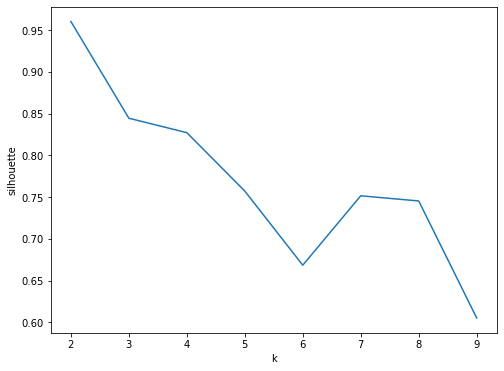

In [14]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('silhouette')

## Bisecting Kmeans

In [21]:
bkm = BisectingKMeans(featuresCol='standardized', k=3, seed=42)
    
bkm = bkm.fit(data_scale_output)
    
output= bkm.transform(data_scale_output)

In [22]:
dist_clusters = output.select("prediction").distinct().rdd.map(lambda x: x[0]).collect()
dd = {}
for j in dist_clusters:
    dd[j] = output.filter(output["prediction"] == j).select(features_cluster+features_other+features_numeric)

In [23]:
def basic_statistics(df):
    for i in df.dtypes:
        if(i[1] == 'int' or i[1] == 'double' or i[1] == 'float' or i[1] == 'bigint'):
            df.describe(i[0]).show(truncate=False)

for i in dist_clusters:
    print("----------- Statistiche cluster n°: " + str(i) + " --------")
    basic_statistics(dd[i].select(features_cluster))

----------- Statistiche cluster n°: 1 --------
+-------+----------------------+
|summary|Reviews_Installs_Ratio|
+-------+----------------------+
|count  |410427                |
|mean   |0.11109354884040736   |
|stddev |36.84925364123248     |
|min    |1.2E-7                |
|max    |21921.0               |
+-------+----------------------+

+-------+------------------+
|summary|Size              |
+-------+------------------+
|count  |410427            |
|mean   |20.252285161583515|
|stddev |24.598761694335344|
|min    |9.765625E-4       |
|max    |1126.4            |
+-------+------------------+

+-------+------------------+
|summary|Rating            |
+-------+------------------+
|count  |410427            |
|mean   |3.4847814593092963|
|stddev |0.4731042861559817|
|min    |2.1               |
|max    |4.0               |
+-------+------------------+

+-------+-------------------+
|summary|Price              |
+-------+-------------------+
|count  |410427             |
|mean   |0.

In [24]:
for i in dist_clusters:
    print("----------- Info categorici cluster n°: " + str(i) + " --------")
    for j in features_other:
        dd[i].createOrReplaceTempView("tmp")
        tot_j = dd[i].select(j).count()
        query = spark.sql("SELECT "+str(j)+", count(*)/"+str(tot_j)+" * 100 FROM tmp GROUP BY "+ str(j) + ";")
        print("<<-- feature:"+ str(j))
        query.show()

----------- Info categorici cluster n°: 1 --------
<<-- feature:Ad_Supported
+------------+---------------------------------------------------------------------------+
|Ad_Supported|((CAST(count(1) AS DOUBLE) / CAST(410427 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+------------+---------------------------------------------------------------------------+
|        true|                                                          57.30958245924367|
|       false|                                                         42.690417540756336|
+------------+---------------------------------------------------------------------------+

<<-- feature:Category
+----------------+---------------------------------------------------------------------------+
|        Category|((CAST(count(1) AS DOUBLE) / CAST(410427 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+----------------+---------------------------------------------------------------------------+
|   Music & Audio|                                                   

<<-- feature:Year_of_Release
+---------------+---------------------------------------------------------------------------+
|Year_of_Release|((CAST(count(1) AS DOUBLE) / CAST(410427 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+---------------+---------------------------------------------------------------------------+
|           2018|                                                         15.428078562082902|
|           2015|                                                         7.7563123283799555|
|           2013|                                                         3.9005718434703374|
|           2014|                                                          5.943078793549157|
|           2019|                                                         18.279986453132956|
|           2020|                                                         17.646987162150637|
|           2012|                                                         2.4474510692522666|
|           2016|              

<<-- feature:Editors_Choice
+--------------+---------------------------------------------------------------------------+
|Editors_Choice|((CAST(count(1) AS DOUBLE) / CAST(683742 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+--------------+---------------------------------------------------------------------------+
|          true|                                                        0.07020191826741666|
|         false|                                                          99.92979808173259|
+--------------+---------------------------------------------------------------------------+

<<-- feature:In_App_Purchases
+----------------+---------------------------------------------------------------------------+
|In_App_Purchases|((CAST(count(1) AS DOUBLE) / CAST(683742 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+----------------+---------------------------------------------------------------------------+
|            true|                                                         11.555528254809563|
|  

<<-- feature:Developer_Id
+--------------------+---------------------------------------------------------------------------+
|        Developer_Id|((CAST(count(1) AS DOUBLE) / CAST(995683 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+--------------------+---------------------------------------------------------------------------+
|             Judo id|                                                       1.004335717291547...|
|  Professional amera|                                                       0.001707370719395631|
|Appgoo Apps - Rad...|                                                       0.019383679343726867|
|         KERISH APPS|                                                       0.001004335717291...|
|      Nada Salsabila|                                                       7.030350021040834E-4|
|         Oualidosdev|                                                       0.004519510727811964|
|          河豚沒了刺|                                                       1.004335717